In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image


from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
pat_fold = "F:/Data_Breast_Cancer/IDC_regular_ps50_idx5/"
folder = listdir(pat_fold)
len(folder)

279

In [3]:
cancer_img = glob.glob('F:/Data_Breast_Cancer/IDC_regular_ps50_idx5/**/*.png', recursive = True)
len(cancer_img)


277524

Notre base est composé de 279 patients. Le nombre total d'image est de 277524

# Exploration et analyse des données
## Visualisation des données

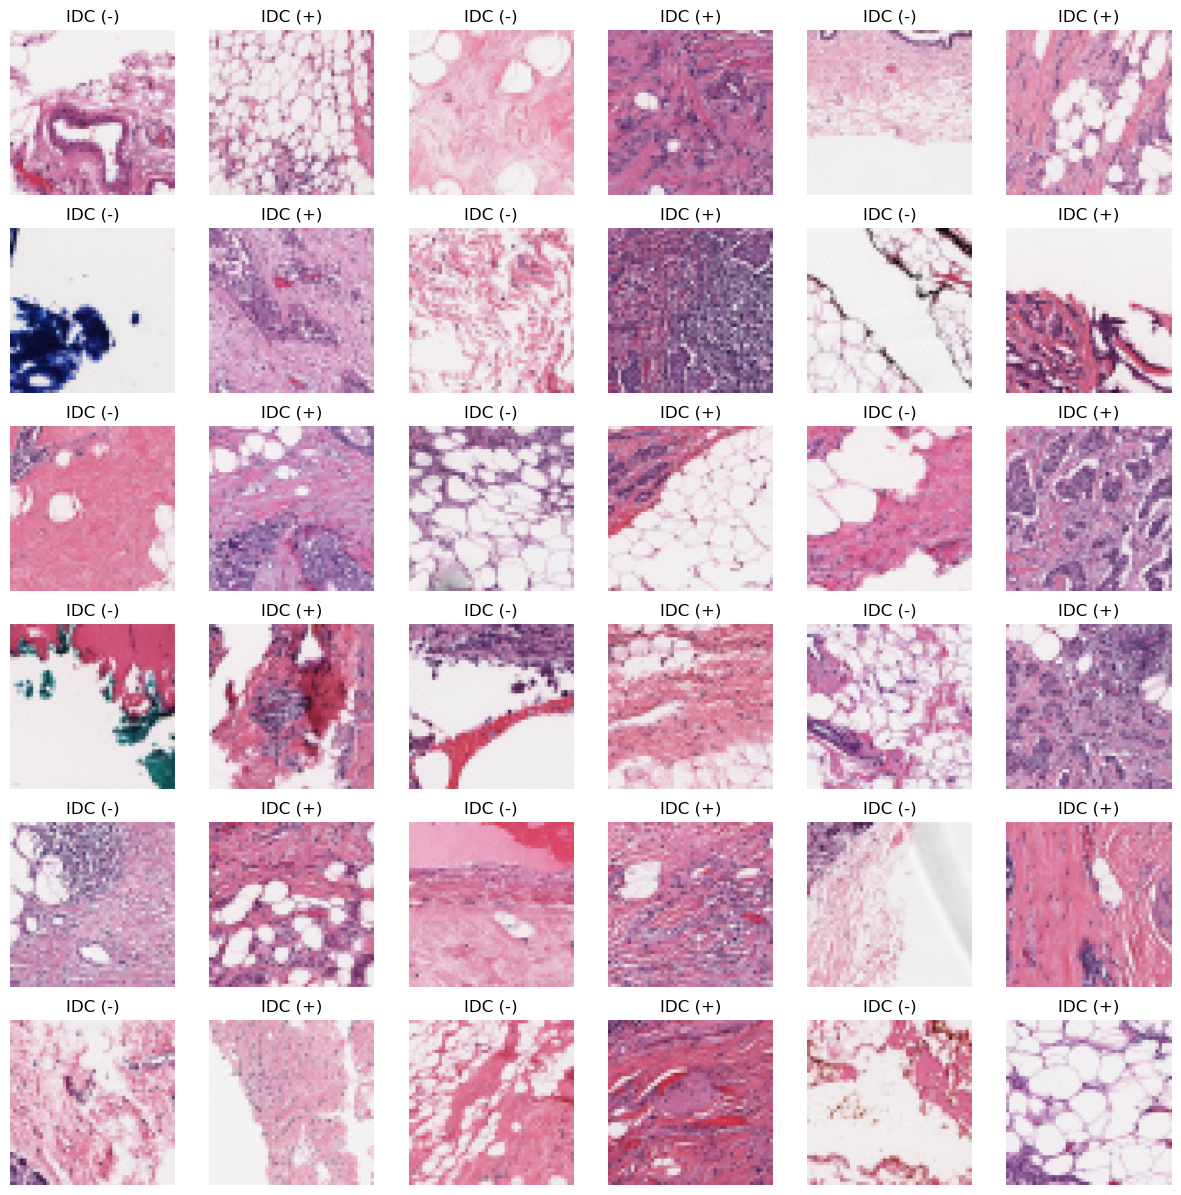

In [4]:
# Groupage des femmes Cancer + et Cancer -

N_IDC = [img for img in cancer_img if img[-5] == '0']
Y_IDC = [img for img in cancer_img if img[-5] == '1']
plt.figure(figsize=(15, 15))

# Sélection aléatoire d'indices pour les images sans cancer et avec cancer
indices_non_cancer = np.random.choice(len(N_IDC), size=18, replace=False)
indices_cancer = np.random.choice(len(Y_IDC), size=18, replace=False)

# Affichage des images sans cancer
for i, idx in enumerate(indices_non_cancer):
    img = image.load_img(N_IDC[idx], target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*i + 1)
    plt.axis('off')
    plt.title('IDC (-)')
    plt.imshow(img.astype('uint8'))

# Affichage des images avec cancer
for i, idx in enumerate(indices_cancer):
    img = image.load_img(Y_IDC[idx], target_size=(100, 100))
    img = image.img_to_array(img)
    plt.subplot(6, 6, 2*i + 2)
    plt.axis('off')
    plt.title('IDC (+)')
    plt.imshow(img.astype('uint8'))

plt.show()


In [5]:
# Nombre de femmes sans cancer (IDC négatif)
nb_femmes_negatif = len(N_IDC)

# Nombre de femmes avec cancer (IDC positif)
nb_femmes_positif = len(Y_IDC)

print("Nombre de femmes avec cancer (IDC positif) :", nb_femmes_positif)
print("Nombre de femmes sans cancer (IDC négatif) :", nb_femmes_negatif)


Nombre de femmes avec cancer (IDC positif) : 78786
Nombre de femmes sans cancer (IDC négatif) : 198738


Dans notre base de données 198738  sont négatifs du cancer contre 78786 négatifs

# Traitement et normalisation des images

Etant donnée donné que nous allons utilisé les réseaux neuronaux convolutionnels (CNN) comme algorithme d'apprentissage, nous proposons de sélectionner le même nombre d'image dans les deux classes àfin d'aider à équiliber les classes et à éviter tout biaiss dans le modèle d'apprentissage. Pour ce ce faire nous allons séléctionné 78786 images de femmes n'ayant pas de cancer et nous garderons les 78786 des femmes cancer + pour faire le traitement



In [6]:
N_IDC_new=N_IDC[:78786]
print(len(N_IDC_new))
print(len(Y_IDC))

78786
78786


In [7]:
# Ici nous normalisons les images et les stockons dans des tableux

N_Canc_img_arr = []
Y_can_img_arr = []

# Traitement des images sans cancer (IDC négatif)
for img in N_IDC_new:
   n_img = cv2.imread(img, cv2.IMREAD_COLOR)
   if n_img is not None:
       n_img_size = cv2.resize(n_img, (25, 25), interpolation=cv2.INTER_LINEAR)
       n_img_size = n_img_size.astype('float32') / 255.0  
       # Normalisation des pixels
       N_Canc_img_arr.append([n_img_size, 0])


In [8]:
# Traitement des images avec cancer (IDC positif)
for img in Y_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    if c_img is not None:
        c_img_size = cv2.resize(c_img, (25, 25), interpolation=cv2.INTER_LINEAR)
        c_img_size = c_img_size.astype('float32') / 255.0 
         # Normalisation des pixels
        Y_can_img_arr.append([c_img_size, 1])


        from skimage.transform import resize

# Préparation des données d'entrainement et de test

In [9]:
X = []
y = []

# Concaténer les listes de caractéristiques et d'étiquettes
img_canc = N_Canc_img_arr[:15000] + Y_can_img_arr[:15000] # pas beacoup de mémoire donc nous optons pour une sélection de 20000 images 
# par classe
# Mélanger aléatoirement les éléments de la liste
random.shuffle(img_canc)

# Parcourir la liste concaténée et extraire les caractéristiques et les étiquettes
for feature, label in img_canc:
    X.append(feature)
    y.append(label)
    
# Convertir les listes en tableaux numpy
X = np.array(X)
y = np.array(y)


## Division des données en ensemble de test et d'entrainement
 70% des données seront reservées pour l'entrainement et 30% pour le test


In [10]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
#y_train = to_categorical(y_train, num_classes = 2)
#y_test = to_categorical(y_test, num_classes = 2)

print("Taille de données d'entrainement X:", X_train.shape)
print("Taille de données d'entrainement Y :", y_train.shape)
print("Taille de données de test X :", X_test.shape)
print("Taille de données de test Y :", y_test.shape)

Taille de données d'entrainement X: (21000, 25, 25, 3)
Taille de données d'entrainement Y : (21000,)
Taille de données de test X : (9000, 25, 25, 3)
Taille de données de test Y : (9000,)


## Définition du modèle


Nous allons crér un modèle séquentiel convolutif simple  composé des couches suivantes :

* Tois couches de convolution avec respectivement 32, 64 et 128 filtres, une taille de noyau de (3, 3) et une activation ReLU.
* Trois couches de max pooling avec un pool size de (2, 2) pour réduire la dimensionnalité.
* Une couche flatten pour convertir les données en un vecteur 1D afin de les alimenter dans les couches fully-connected.
* Une couche dense avec 128 neurones et une activation ReLU pour extraire des caractéristiques plus abstraites.
* Une couche dropout avec un taux de régularisation de 0.5 pour éviter le surajustement.
* Enfin, une couche dense de sortie avec une activation sigmoid pour effectuer la classification binaire.

L'optimisateur utilisé ici est "Adam" avec un taux d'apprentissage de 0.001 et "binary_crossentropy" comme fonction de perte car nous sommes dans un cas de classification binaire \
La métique "accuracy" est également utilisé pour surveiller l'exactitude du modèle pendant l'entraînement.

In [11]:
def modele_CNN():
    early_stop=EarlyStopping(monitor='val_loss',patience=5)
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(25, 25, 3)))
    

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
      
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Couche de sortie pour la classification binaire
    model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   
    return model

# Créer le modèle
CNN_mod = modele_CNN()

# Afficher un résumé du modèle
CNN_mod.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 128)         0         
 g2D)                                                 

# Entrainement du modèle

Notre modèle sera entrainer en utilisant la validation croisé "K-fold" pour évaluer la performance du modèle. Les données sont alors partitionné en 5 (k=5) sous ensembles de tailles égales. \
Le modèle est entrainé 5 fois avec chacune des sous  données d'entrainement et de test. \
La performence du modèle est moyennée sur les 5 itérations pour obténir l'estimation global de la performance du modèle. 

Epoch 1/40


525/525 [==============================] - 20s 31ms/step - loss: 0.5416 - accuracy: 0.7200 - val_loss: 0.4596 - val_accuracy: 0.8000
Epoch 2/40
525/525 [==============================] - 16s 30ms/step - loss: 0.4566 - accuracy: 0.7983 - val_loss: 0.4539 - val_accuracy: 0.8131
Epoch 3/40
525/525 [==============================] - 14s 27ms/step - loss: 0.4483 - accuracy: 0.8005 - val_loss: 0.4468 - val_accuracy: 0.8131
Epoch 4/40
525/525 [==============================] - 14s 27ms/step - loss: 0.4407 - accuracy: 0.8074 - val_loss: 0.4606 - val_accuracy: 0.8005
Epoch 5/40
525/525 [==============================] - 13s 26ms/step - loss: 0.4325 - accuracy: 0.8112 - val_loss: 0.4338 - val_accuracy: 0.8217
Epoch 6/40
525/525 [==============================] - 15s 28ms/step - loss: 0.4240 - accuracy: 0.8148 - val_loss: 0.4583 - val_accuracy: 0.8040
Epoch 7/40
525/525 [==============================] - 14s 27ms/step - loss: 0.4183 - accuracy: 0.8193 - val_loss: 0.4257 - val_accurac

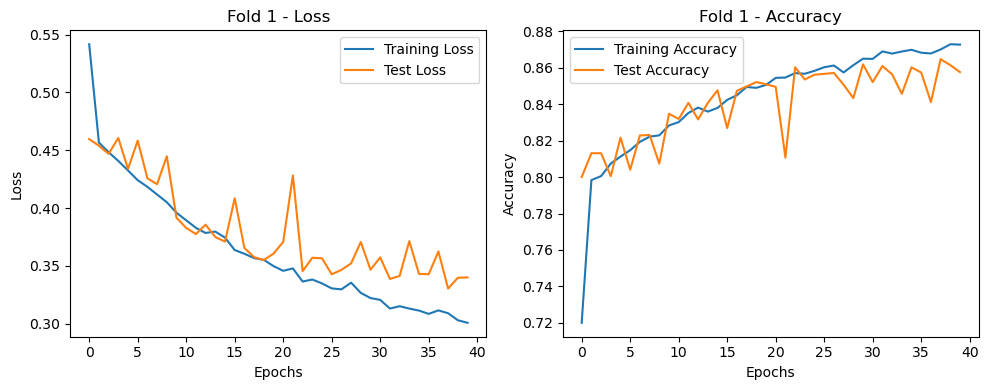

Epoch 1/40
525/525 [==============================] - 16s 28ms/step - loss: 0.5298 - accuracy: 0.7304 - val_loss: 0.4574 - val_accuracy: 0.8005
Epoch 2/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4537 - accuracy: 0.7999 - val_loss: 0.4548 - val_accuracy: 0.7998
Epoch 3/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4414 - accuracy: 0.8064 - val_loss: 0.4538 - val_accuracy: 0.8074
Epoch 4/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4355 - accuracy: 0.8107 - val_loss: 0.4413 - val_accuracy: 0.8202
Epoch 5/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4298 - accuracy: 0.8126 - val_loss: 0.4216 - val_accuracy: 0.8188
Epoch 6/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4235 - accuracy: 0.8161 - val_loss: 0.4250 - val_accuracy: 0.8219
Epoch 7/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4131 - accuracy: 0.8198 - val_loss: 0.4064 - val_accuracy:

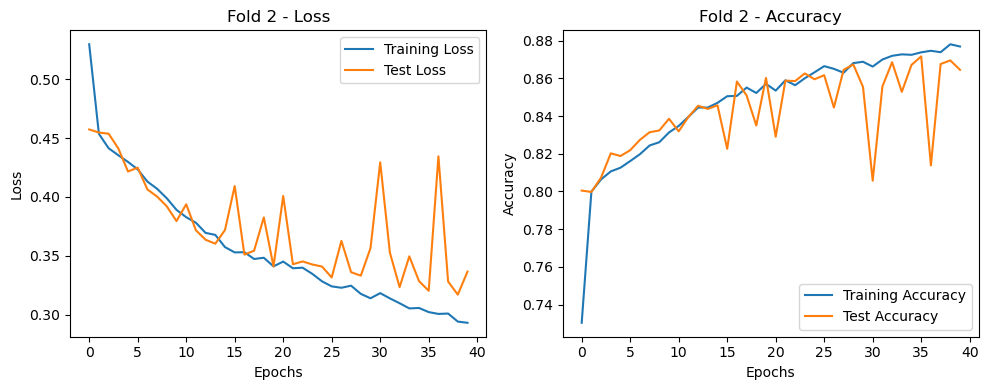

Epoch 1/40
525/525 [==============================] - 15s 26ms/step - loss: 0.5180 - accuracy: 0.7462 - val_loss: 0.4941 - val_accuracy: 0.7831
Epoch 2/40
525/525 [==============================] - 13s 26ms/step - loss: 0.4520 - accuracy: 0.8017 - val_loss: 0.4614 - val_accuracy: 0.8055
Epoch 3/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4475 - accuracy: 0.8039 - val_loss: 0.4499 - val_accuracy: 0.8069
Epoch 4/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4344 - accuracy: 0.8118 - val_loss: 0.4484 - val_accuracy: 0.8083
Epoch 5/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4295 - accuracy: 0.8148 - val_loss: 0.4751 - val_accuracy: 0.7883
Epoch 6/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4212 - accuracy: 0.8166 - val_loss: 0.4392 - val_accuracy: 0.8086
Epoch 7/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4130 - accuracy: 0.8209 - val_loss: 0.4336 - val_accuracy:

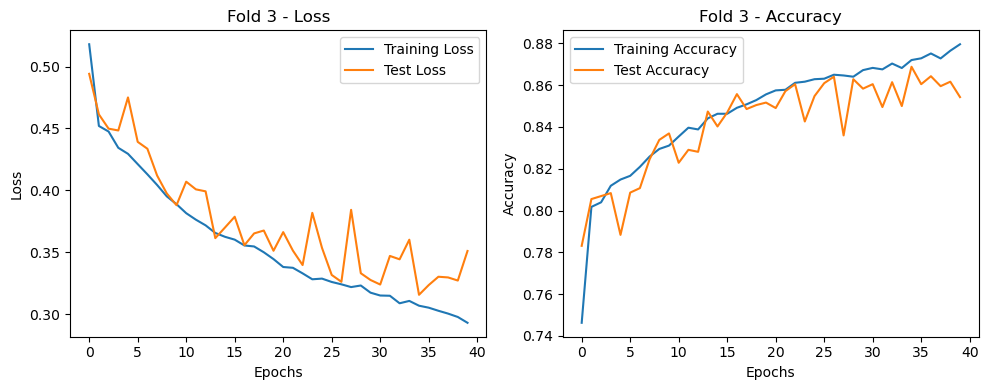

Epoch 1/40
525/525 [==============================] - 14s 25ms/step - loss: 0.5180 - accuracy: 0.7509 - val_loss: 0.4679 - val_accuracy: 0.8007
Epoch 2/40
525/525 [==============================] - 13s 24ms/step - loss: 0.4584 - accuracy: 0.7996 - val_loss: 0.4649 - val_accuracy: 0.7919
Epoch 3/40
525/525 [==============================] - 13s 25ms/step - loss: 0.4518 - accuracy: 0.8033 - val_loss: 0.4687 - val_accuracy: 0.7869
Epoch 4/40
525/525 [==============================] - 13s 24ms/step - loss: 0.4433 - accuracy: 0.8074 - val_loss: 0.4530 - val_accuracy: 0.8064
Epoch 5/40
525/525 [==============================] - 13s 24ms/step - loss: 0.4368 - accuracy: 0.8103 - val_loss: 0.4374 - val_accuracy: 0.8083
Epoch 6/40
525/525 [==============================] - 13s 24ms/step - loss: 0.4317 - accuracy: 0.8136 - val_loss: 0.4496 - val_accuracy: 0.8079
Epoch 7/40
525/525 [==============================] - 13s 24ms/step - loss: 0.4289 - accuracy: 0.8147 - val_loss: 0.4263 - val_accuracy:

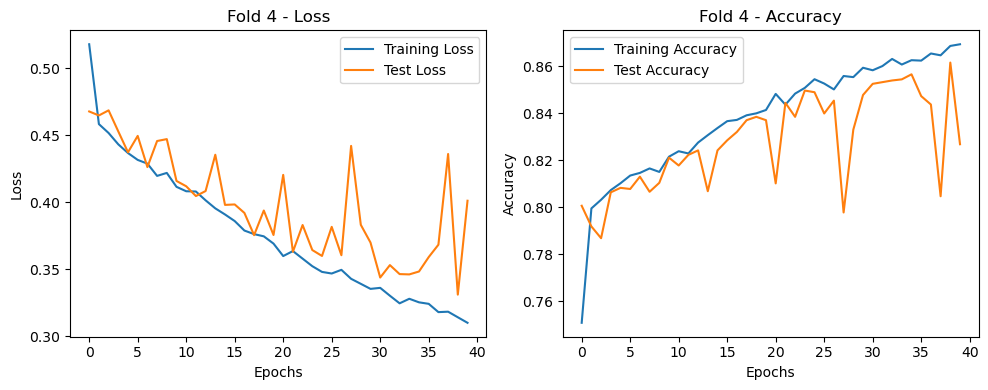

Epoch 1/40
525/525 [==============================] - 15s 26ms/step - loss: 0.5283 - accuracy: 0.7384 - val_loss: 0.4637 - val_accuracy: 0.8119
Epoch 2/40
525/525 [==============================] - 14s 27ms/step - loss: 0.4590 - accuracy: 0.7996 - val_loss: 0.4448 - val_accuracy: 0.8064
Epoch 3/40
525/525 [==============================] - 14s 26ms/step - loss: 0.4502 - accuracy: 0.8008 - val_loss: 0.4776 - val_accuracy: 0.7981
Epoch 4/40
525/525 [==============================] - 14s 26ms/step - loss: 0.4460 - accuracy: 0.8048 - val_loss: 0.4287 - val_accuracy: 0.8164
Epoch 5/40
525/525 [==============================] - 14s 26ms/step - loss: 0.4387 - accuracy: 0.8073 - val_loss: 0.4317 - val_accuracy: 0.8169
Epoch 6/40
525/525 [==============================] - 14s 26ms/step - loss: 0.4341 - accuracy: 0.8114 - val_loss: 0.4232 - val_accuracy: 0.8224
Epoch 7/40
525/525 [==============================] - 14s 27ms/step - loss: 0.4258 - accuracy: 0.8145 - val_loss: 0.4835 - val_accuracy:

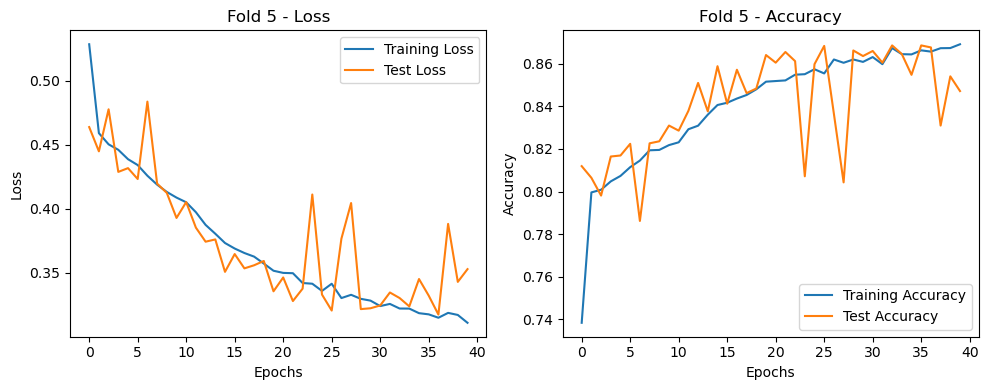

Le score moyen est de : 0.850095248222351


In [12]:

# Définir le nombre de folds pour la validation croisée
k = 5

# Créer un objet StratifiedKFold
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Liste pour stocker les scores de validation pour chaque fold
val_scores = []

# Boucle sur les folds
for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train), 1):
    # Séparer les données en ensembles d'entraînement et de validation pour ce fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Créer, compiler et entraîner votre modèle
    model = modele_CNN() 
   
    # Entraîner le modèle avec validation croisée
    history = model.fit(X_train_fold, y_train_fold, epochs=40, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Évaluer le modèle sur l'ensemble de validation et enregistrer le score
    _, val_score = model.evaluate(X_val_fold, y_val_fold)
    val_scores.append(val_score)

    # Afficher les courbes de perte et de précision pour l'entraînement et la validation
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Fold {} - Loss'.format(fold))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Fold {} - Accuracy'.format(fold))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Calculer la moyenne des scores de validation
mean_val_score = np.mean(val_scores)
print("Le score moyen est de :", mean_val_score)
